<h2>The constructed dataset is analyzed with tf-idf, categorizing with PCA and K-means. Arranging photos with word2vec and wordnet.</h2>

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors
from scipy import spatial

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator

/home/tim/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


<b>Measuring semantic similarity</b>
<br>
Using a pretrained model of word2vec from google containing word vectors for 3 million words and phrases:<br>
"https://code.google.com/archive/p/word2vec/"
<br>
Setting the limit to 1.500.000

In [2]:
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True, limit=1500000)

<b>Opening data</b>

In [3]:
# 574 entries (photos)
data = pd.read_excel('complete_dataset.xlsx')
data.head()

,PhotoID,Photopath,studentID,Theme,Tags[..],Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,8,/home/tim/Documents/scriptie/data/1/student_we...,1,student_well_being,no person 0.99,still life 0.99,food 0.95,indoors 0.95,sculpture 0.95,grow 0.94,...,light 0.90,table 0.88,interior design 0.87,toy 0.87,flower 0.86,wood 0.86,one 0.85,vase 0.85,furniture 0.83,portrait 0.82
1,4,/home/tim/Documents/scriptie/data/1/student_we...,1,student_well_being,access 1.00,metal key 1.00,lock 1.00,security 1.00,padlock 1.00,unlock 0.99,...,steel 0.97,still life 0.97,jewelry band 0.96,no person 0.96,cutout 0.95,admittance 0.95,door 0.95,keyhole 0.95,one 0.93,chain 0.93
2,6,/home/tim/Documents/scriptie/data/1/student_we...,1,student_well_being,tree 0.99,park 0.98,cemetery 0.97,no person 0.97,fall 0.97,step 0.96,...,bench 0.95,landscape 0.95,wood 0.94,nature 0.93,road 0.93,street 0.92,outdoors 0.91,winter 0.91,leaf 0.91,light 0.91
3,5,/home/tim/Documents/scriptie/data/1/student_we...,1,student_well_being,ball-shaped 0.99,no person 0.99,geography 0.99,planet 0.97,travel 0.97,map 0.97,...,art 0.93,one 0.93,sphere 0.93,round out 0.92,retro 0.90,universe 0.89,cartography 0.88,wood 0.88,traditional 0.87,ancient 0.86
4,7,/home/tim/Documents/scriptie/data/1/student_we...,1,student_well_being,time 1.00,clock 1.00,watch 1.00,precision 0.99,analogue 0.99,wrist 0.99,...,watch over 0.97,timer 0.97,noon 0.97,timepiece 0.96,early 0.96,pressure 0.95,quartz 0.94,dial 0.94,analog 0.93,countdown 0.92


<b>TF-IDF metric on tags</b>
<br>
Collecting the term frequency within a theme

In [4]:
# Return the term frequency matrix for a given theme
# Amount of photo's in a theme that use this tag
def term_frequency_matrix(subset):
    tags = subset.iloc[:, 4:,]
    all_cols = [col for col in tags]
    # Get all unique tags in this theme
    temp = pd.unique(tags[all_cols].values.ravel())
    unique_tags = []
    for tag in temp:
        tag = ' '.join(tag.split(' ')[:-1])
        unique_tags.append(tag)
     
    matrix = []
    unique_tags = set(unique_tags)
    total_nr_tags = len(unique_tags)
    for tag in unique_tags:
        # Check for every tag how many times the tag appears in a column (for this theme)
        term_freq = 0
        for col in tags:
            for t in subset[col]:
                x = ' '.join(t.split(' ')[:-1])
                if x == tag:
                    term_freq += 1
        matrix.append([tag, term_freq])
    matrix.sort(key=lambda x:x[1], reverse=True)
    return np.array(matrix)


In [5]:
anger_set = data.loc[data['Theme'] == 'anger']
network_set = data.loc[data['Theme'] == 'network']
student_well_being_set = data.loc[data['Theme'] == 'student_well_being']
impuls_set = data.loc[data['Theme'] == 'impuls']
climate_change_set = data.loc[data['Theme'] == 'climate_change']
garbage_non_existent_set = data.loc[data['Theme'] == 'garbage_non_existent']
tf_dict = {'anger':term_frequency_matrix(anger_set),
          'network':term_frequency_matrix(network_set),
          'student_well_being':term_frequency_matrix(student_well_being_set),
          'impuls':term_frequency_matrix(impuls_set),
          'climate_change':term_frequency_matrix(climate_change_set),
          'garbage_non_existent':term_frequency_matrix(garbage_non_existent_set)}

In [6]:
print(tf_dict['garbage_non_existent'][:30])


[['no person' '83']
 ['indoors' '38']
 ['family' '35']
 ['people' '33']
 ['business' '32']
 ['wood' '31']
 ['paper' '28']
 ['street' '23']
 ['retro' '23']
 ['color' '23']
 ['old' '22']
 ['food' '21']
 ['container' '21']
 ['plastic' '21']
 ['nature' '20']
 ['desktop' '18']
 ['one' '18']
 ['outdoors' '16']
 ['industry' '15']
 ['travel' '15']
 ['recycling' '15']
 ['technology' '15']
 ['urban' '15']
 ['garbage' '14']
 ['trash' '14']
 ['city' '14']
 ['house' '13']
 ['dirty' '13']
 ['leaf' '13']
 ['clean' '13']]


<b>Calculating the tf-idf score of a tag</b>
<br>
tf = term frequency of a tag within a class / total amount of unique tags within a class
<br>
idf = total number of photos / total frequency of a tag in the entire data
<br>
tf-idf = tf * idf

In [7]:
# Return the idf, the frequency of a given tag in all photos divided by
# the frequency of the tag in this class
# Total number of photos: 574
def get_idf(tf_dict, tag):
    total_freq = 0
    for theme in tf_dict.keys():
        for t in tf_dict[theme]:
            if t[0] == tag:
                total_freq += int(t[1])
    return np.log(np.divide(574, total_freq))

# Return the total amount of unique tags in data
def all_unique_tags(tf_dict):
    tags = []
    for theme in tf_dict.keys():
        for t in tf_dict[theme]:
            tags.append(t[0])
    return len(set(tags))

# Term frequency x inverse document frequency
def tf_idf(tf_dict):
    tf_idf_dict = {}
    for theme in tf_dict.keys():
        total_number_tags = len(tf_dict[theme])
        temp = []
        for i,tag in enumerate(tf_dict[theme][:,0]):
            # tf = term frequency of tag in class / number of tags in this class
            tf = np.divide(int(tf_dict[theme][i][1]), total_number_tags)
            idf = get_idf(tf_dict, tag)
            score = np.multiply(tf,idf)
            temp.append([tag, score])
        temp.sort(key=lambda x:x[1], reverse=True)
        tf_idf_dict[theme] = np.array(temp)
    return tf_idf_dict 

tf_idf_scores = tf_idf(tf_dict)

We now have a dictionary of all unique tags per theme. The tags are sorted on their tf-idf score.

In [8]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
print(tf_idf_scores['climate_change'][:30])

[['outdoors' '0.07303570252665945']
 ['nature' '0.07045536746579582']
 ['industry' '0.06755384335905575']
 ['landscape' '0.06752345660852165']
 ['street' '0.06737685290136328']
 ['sky' '0.06527555171975356']
 ['urban' '0.06512724586051645']
 ['city' '0.06400155219073946']
 ['family' '0.06341261009931451']
 ['summer' '0.06145437360636113']
 ['plastic' '0.06084719950717187']
 ['recycling' '0.05808375973816905']
 ['vehicle' '0.05705350844236911']
 ['technology' '0.056668777110841256']
 ['light' '0.055166940288192926']
 ['container' '0.0547032466923939']
 ['color' '0.05064259245639123']
 ['park' '0.05061083187353665']
 ['indoors' '0.05016510414656069']
 ['transportation system' '0.050085595108867044']
 ['still life' '0.050085595108867044']
 ['leaf' '0.05005108728580662']
 ['H2O' '0.0492606553340424']
 ['road' '0.04882266835088118']
 ['tree' '0.04872877365005871']
 ['architecture' '0.04817739306003387']
 ['car' '0.04786873792781928']
 ['sun' '0.04775527777135727']
 ['steel' '0.0470615728267

In [9]:
from nltk.corpus import wordnet as wn
import nltk
import numpy as np
# Return list of antonyms
def create_antonym_list():
    all_antonyms = []
    for i in wn.all_synsets():
        if i.pos() in ['a','n', 'v']:
            for j in i.lemmas():
                if j.antonyms(): 
                    # Prints the adj-antonym pair.
                    ant = j.name(), j.antonyms()[0].name()
                    all_antonyms.append(ant)
    return all_antonyms

all_antonyms = create_antonym_list()
all_antonyms = sorted(set(tuple(sorted(i)) for i in all_antonyms))
print(len(all_antonyms))

3243


In [10]:
# Returns most relevant antonym for a given word
from pprint import pprint
def most_relevant_antonym(keywords, all_antonyms):
    ranked_antonyms = []
    key_vector = np.zeros((300,))
    for keyword,score in keywords:
        try:
            word_vector = model[keyword] * float(score)
            key_vector = np.add(key_vector, word_vector)
            #print(keyword,score)
        except:
            continue
    for ant_tuple in all_antonyms:
        final_score = 0
        score1 = 0 
        score2 = 0
        try:
            ant_vector0 = model[ant_tuple[0]]
            if len(wn.synsets(ant_tuple[0])) != 0:
                score1 = np.dot(key_vector, ant_vector0) /\
                (np.linalg.norm(key_vector) * np.linalg.norm(ant_vector0))

            ant_vector1 = model[ant_tuple[1]]
            if len(wn.synsets(ant_tuple[1])) != 0:
                score2 = np.dot(key_vector, ant_vector1) /\
                (np.linalg.norm(key_vector) * np.linalg.norm(ant_vector1))
        except KeyError:
            continue
        if score1 > score2:
            final_score = score1
        else:
            final_score = score2

        ranked_antonyms.append((ant_tuple) + (final_score,))      
    ranked_antonyms = sorted(ranked_antonyms, key=lambda x:x[2], 
                             reverse=True)[:10]
    return ranked_antonyms

best_antonyms = {}
for theme in tf_idf_scores.keys():
    keywords = tf_idf_scores[theme][:30]
    best_antonyms[theme] = most_relevant_antonym(keywords, all_antonyms)

    

for theme in best_antonyms.keys():
    print(theme)
    pprint(best_antonyms[theme])
    print()


anger
[('monochromatic', 'polychromatic', 0.5425499085768815),
 ('nonrepresentational', 'representational', 0.5418884507707663),
 ('nonreflective', 'reflective', 0.53059860309443),
 ('painted', 'unpainted', 0.5256806881724748),
 ('exterior', 'interior', 0.5169978940047513),
 ('carpeted', 'uncarpeted', 0.5161821212135252),
 ('achromatic', 'chromatic', 0.5033745827347217),
 ('abstract', 'concrete', 0.4904702230606539),
 ('glazed', 'unglazed', 0.4874037220524668),
 ('swept', 'unswept', 0.4618721981431998)]

network
[('wired', 'wireless', 0.49962881408276993),
 ('analogue', 'digital', 0.47205086380575617),
 ('hardware', 'software', 0.46624582862200814),
 ('immobile', 'mobile', 0.44927438603953673),
 ('mobile', 'stabile', 0.44927438603953673),
 ('obvious', 'unobvious', 0.4110047802534467),
 ('unwearable', 'wearable', 0.40979600528664645),
 ('intangibility', 'tangibility', 0.40817640224811513),
 ('technophile', 'technophobe', 0.3906446678519262),
 ('abstractness', 'concreteness', 0.387723249

In [11]:


# Get the sum vector for a photo based on 20 tags.
# The sum vector is taken by summing up all word vectors

def get_sum_vector(row, theme, model):
    row_vector = np.zeros((300, ))
    word_count = 0
    for cell in row[4:]:
        tag = ' '.join(cell.split(' ')[:-1])
        # Ignore 'no person'
        if tag ==  'no person':
            continue
        tag = tag.split()[-1]
        # Remove brackets
        if tag[0] == '(':
            tag = tag.strip("()")
        try:
            word_vector = model[tag]
            # Sum of Word Embeddings
            for t,v in tf_idf_scores[theme]:
                if t == tag:
                    word_vector = word_vector * float(v)
                    break
            row_vector = np.add(row_vector, word_vector)
            word_count += 1
        except KeyError:
            pass

    row_vector = row_vector/word_count
        # L1 normalized sum of word vectors
    normalized_row_vector = row_vector / np.linalg.norm(row_vector)
    return list(row_vector)

# Kmeans
def get_clusters(all_vectors, k):
    clustering_model = KMeans(n_clusters=k)
    return clustering_model.fit_predict(all_vectors)


# Silhouette method to determine optimal k
def find_optimal_k(all_vectors):
    model = KMeans(n_clusters=(2,10), random_state=22)
    visualizer = KElbowVisualizer(model, k=(2,10) ,metric='silhouette')
    vis = KElbowVisualizer(model, k=(2,10))
    visualizer.fit(all_vectors)
    visualizer.show()        # Finalize and render the figure
    vis.fit(all_vectors)
    vis.show()
    scores = []
    label_list = []
    n_clusters = np.arange(2,10)
    for n_clus in n_clusters:
        model = KMeans(n_clusters=n_clus, random_state=22)
        labels = model.fit_predict(all_vectors)
        scores.append([n_clus, silhouette_score(all_vectors, labels)])
        label_list.append(labels)
    scores=np.array(scores)
    kneedle = KneeLocator(scores[:,0], scores[:,1], S=1.0, curve="concave", direction="increasing")

    
    all_elbows = list(kneedle.all_elbows)
    if all_elbows == []:
        all_elbows.append(4)
    optimal_k = int(all_elbows[0])
    return optimal_k, label_list[optimal_k-2]
        
# Combine vectors of all photo's into an array
def construct_vector_set(subset):
    all_vectors = []
    for i, row in enumerate(subset):
        vector = get_sum_vector(row, theme, model)
        all_vectors.append(vector)
    all_vectors = np.array(all_vectors)
    return all_vectors

# Plot the pca of the word2vec vectors
def generate_cluster_labels(similarity_vectors,subset):
    pca = PCA(n_components=0.75)
    pca_data = pca.fit_transform(similarity_vectors)  
    print("Number of principal components:")
    print(pca.n_components_)
    optimal_k, labels = find_optimal_k(pca_data)

    from collections import Counter
    cluster_keys = Counter(list(labels)).keys()
    cluster_size = Counter(list(labels)).values()
    delete_keys = []
    for i,count in enumerate(list(cluster_size)):
        # If cluster size is smaller than 3, delete it
        if count < 3:
            delete_keys.append(list(cluster_keys)[i])
            optimal_k -= 1

    for i, label in enumerate(labels):
        if label in delete_keys:
            similarity_vectors = np.delete(similarity_vectors, i, 0)
            subset = np.delete(subset, i, 0)
            pca_data = np.delete(pca_data, i, 0)

    # Get cluster labels
    clusters = get_clusters(pca_data, optimal_k)
    result = np.c_[subset, clusters]
    # Return data of this theme with respective cluster label
    return result, optimal_k


In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


Ranking of most optimal K clusters: network
Number of principal components:
9


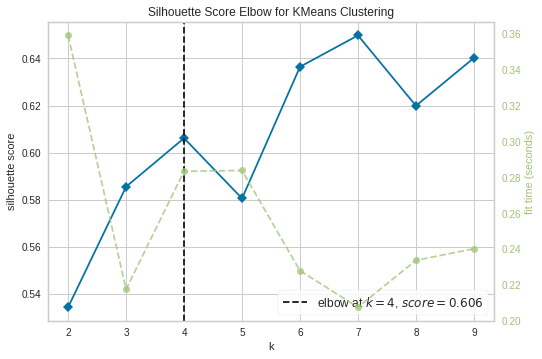

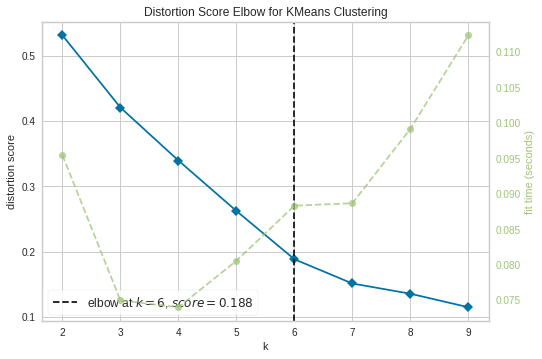

In [13]:
from scipy.signal import argrelextrema
themes = data.Theme.unique()
clusters = {}
n_clusters_ranking = {}
theme = 'network'
subset = data.loc[data['Theme'] == theme]
subset = subset.to_numpy()
similarity_vectors = construct_vector_set(subset)
print("Ranking of most optimal K clusters: " + theme)
clust, k = generate_cluster_labels(similarity_vectors, subset)
clust_sort = sorted(zip(clust[:,0], clust[:,-1]), key = lambda x: x[1])
n_clusters_ranking[theme] = k
clusters[theme] = clust_sort

In [14]:
for theme in n_clusters_ranking.keys():
    print(theme)
    print(n_clusters_ranking[theme])
    print()
#print(clusters['garbage_non_existent'])

network
4



<b> View clusters of photos by copying them in a new cluster directory for evaluation</b>
<br>


In [15]:
# import os.path
# from os import path
# import glob
# from shutil import copyfile
# import shutil

In [17]:
# my_path = #PATH_TO_DIRECTORY

# if path.exists(my_path):
#     shutil.rmtree(my_path)
# os.mkdir(my_path)

In [ ]:

theme = 'student_well_being'
# for theme in themes:
subset = data.loc[data['Theme'] == theme]
subset_array = subset.to_numpy()
path = my_path '+str(theme)
os.mkdir(path)
for row in subset_array:
    for photoid, label in clusters[theme]:
        if row[0] == photoid:
            src = row[1]
            shutil.copy2(src, path)
        

<b>Topic modelling</b>
<br>
Generate the most relevant tags in a cluster
by calculating the tf-idf cluster based score of a tag

In [ ]:
cols = data.columns
top_keywords = {}
for theme in clusters.keys():
    subset = data.loc[data['Theme'] == theme]
    subset_array = subset.to_numpy()
    labels = [x[1] for x in clusters[theme]]
    number_of_clusters = len(np.unique(labels))
    cluster_list = [[] for i in range(number_of_clusters)]
    for row in subset_array:
        for photoid, label in clusters[theme]:
            if row[0] == photoid:
                cluster_list[label].append(row)
    
    tmp = {}
    for i, c in enumerate(cluster_list):
        c = pd.DataFrame(np.array(c), columns = [cols])
        c = term_frequency_matrix(c)
        tmp[i] = c
    top_keywords[theme] = tf_idf(tmp)

In [ ]:
for theme in top_keywords.keys():
    print(theme)
    for clus in top_keywords[theme]:
        print(clus)
        for c in top_keywords[theme][clus][:10]:
            print(c)

<b>Get hypernyms from top keywords</b>

In [ ]:
def get_best_hypernyms(cluster):
    hypernyms = []
    vector_set = []
    word_set = []
    for word, score in cluster:
        if word == 'no person':
            continue
        if ' ' in word:
            word = word.replace(' ', '_')
        try:
            #print(word, score)
            word_vector = model[word]
            word_set.append([word, score])
            vector_set.append(word_vector)
        except KeyError:
            continue
            
    pca = PCA(0.75)
    pca_data = pca.fit_transform(vector_set)
    optimal_k,_ = find_optimal_k(pca_data)
    clusters = get_clusters(pca_data, optimal_k)
    
    tmp = [[] for i in range(optimal_k)]
    for i, label in enumerate(clusters):
        word, score = word_set[i]
        tmp[label].append([word, score])

    for i,clus in enumerate(tmp):
        best_score = 0
        best_hypernym = ''
        for word, score in clus:
            score = float(score)
            if score > best_score:
                best_score = score
                best_hypernym = word
        hypernyms.append([best_hypernym, best_score])
    hypernyms = sorted(hypernyms, key=lambda x: x[1], reverse=True)
    return np.array(hypernyms)

# Top 10 keywords
best_hypernyms = {}
for theme in top_keywords.keys():
    tmp = []
    for clus in top_keywords[theme]:
        cluster = top_keywords[theme][clus][:10]
        best_hypernyms_cluster = get_best_hypernyms(cluster)
        tmp.append(best_hypernyms_cluster)
    best_hypernyms[theme] = tmp
print(best_hypernyms)


<b>Writing result to txt file</b>

In [ ]:
final_result = open('final_result.txt', 'a')
for theme in best_hypernyms.keys():
    categories = []
    suggestions = []
    final_result.write(theme + '\n')
    final_result.write('Best antonyms in this theme \n')
    antonyms = [str(i) + str(elem) + '\n' 
                 for i,elem in enumerate(best_antonyms[theme], 1)]
    final_result.writelines(antonyms)
    final_result.write('\n')
    for i, clus in enumerate(best_hypernyms[theme], 1):
        categories.append(list(clus[0]))
        suggestions.append(clus[1:])
    final_result.write('Suggested number of clusters: ')
    final_result.write(str(n_clusters_ranking[theme]) + '\n')
    final_result.writelines('Best_hypernyms for ' +
                            str(len(categories)) + ' clusters: \n')
    hypernyms = [str(i) + str(elem) + '\n' 
                 for i,elem in enumerate(np.array(categories), 1)]
    final_result.writelines(hypernyms)
    final_result.write('\n')
    final_result.write('Suggestions: \n')
    for i, sug in enumerate(suggestions, 1):
        final_result.write('For cluster ' + str(i) + ': \n')
        final_result.write(str(i) + str(sug) + '\n')
    final_result.write('+++++++++++++++++++++++++++++++++++++++++++++++++\n')
    final_result.write('++++++++++++++++++++ Next Theme +++++++++++++++++\n')
    final_result.write('+++++++++++++++++++++++++++++++++++++++++++++++++')
    final_result.write('\n')
final_result.close()

<b>Create excel file with keywords of every cluster in a theme</b>

In [ ]:
# import xlsxwriter
# themes = data.Theme.unique()

# for theme in top_keywords.keys():
#     column = 0
#     name = 'keywords_' + str(theme) + '.xlsx'
#     workbook = xlsxwriter.Workbook(name)
#     worksheet = workbook.add_worksheet()
#     for i,cluster in enumerate(top_keywords[theme].values()):
#         row = 0
#         worksheet.write(row, column, "Cluster_" + str(i) + '_tag')
#         worksheet.write(row, column+1, "Cluster_" + str(i) + '_score')
#         row += 1
#         for tag, score in cluster:
#             worksheet.write(row, column, tag)
#             worksheet.write(row, column + 1, score)
#             row += 1
#         column +=2
#     workbook.close()